In [100]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, Binarizer, OrdinalEncoder, OneHotEncoder)
from sklearn.metrics import (confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve)
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import folium

In [101]:
necessary = False
if necessary:
    df = pd.read_csv('vehicles.csv')

    # define the number of parts to split the dataframe
    num_parts = 20

    # calculate the number of rows in each part
    rows_per_part = len(df) // num_parts

    # split the dataframe into multiple parts
    for i in range(num_parts):
        start_idx = i * rows_per_part
        end_idx = start_idx + rows_per_part
        if i == num_parts - 1:
            end_idx = len(df)
        df_part = df[start_idx:end_idx]
        df_part.to_csv(f'part_{i+1}.csv', index=False)
        
if not necessary:
    # concatenate the 20 CSV files into a single DataFrame
    df_list = []
    for i in range(1, 21):
        filename = f"part_{i}.csv"
        df_part = pd.read_csv(filename)
        df_list.append(df_part)
    df = pd.concat(df_list)

    # reset the index of the concatenated DataFrame
    df.reset_index(drop=True, inplace=True)


In [102]:
df.head(10)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
5,7222379453,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1600,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
6,7221952215,https://hudsonvalley.craigslist.org/cto/d/west...,hudson valley,https://hudsonvalley.craigslist.org,1000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
7,7220195662,https://hudsonvalley.craigslist.org/cto/d/poug...,hudson valley,https://hudsonvalley.craigslist.org,15995,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
8,7209064557,https://medford.craigslist.org/cto/d/grants-pa...,medford-ashland,https://medford.craigslist.org,5000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN,NaN
9,7219485069,https://erie.craigslist.org/cto/d/erie-2012-su...,erie,https://erie.craigslist.org,3000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN,NaN


In [103]:
### Printing summary of raw data
print(df.shape)
df.columns

(426880, 26)


Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

In [104]:
df.describe()

,id,price,year,odometer,county,lat,long
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05,0.0,420331.000000,420331.000000
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04,NaN,38.493940,-94.748599
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05,NaN,5.841533,18.365462
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00,NaN,-84.122245,-159.827728
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04,NaN,34.601900,-111.939847
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04,NaN,39.150100,-88.432600
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05,NaN,42.398900,-80.832039
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07,NaN,82.390818,173.885502


In [105]:
df['posting_date'].apply(lambda x: str(x)[:4]).unique()

array(['nan', '2021'], dtype=object)

In [106]:
# Number of non-null values in each column
missing_values = (df.isna().sum()/df.shape[0]).sort_values(ascending=False)
print(missing_values)

county          1.000000
size            0.717675
cylinders       0.416225
condition       0.407852
VIN             0.377254
drive           0.305863
paint_color     0.305011
type            0.217527
manufacturer    0.041337
title_status    0.019308
lat             0.015342
long            0.015342
model           0.012362
odometer        0.010307
fuel            0.007058
transmission    0.005988
year            0.002823
description     0.000164
image_url       0.000159
posting_date    0.000159
url             0.000000
price           0.000000
state           0.000000
region_url      0.000000
region          0.000000
id              0.000000
dtype: float64


In [107]:
np.count_nonzero(df[['price','VIN']].value_counts().duplicated())

122079

In [108]:

def count_duplicates(df, col_names):
    # Find duplicated values in the specified columns
    duplicated_values = df[df.duplicated(subset=col_names, keep=False)]

    # Count the number of duplicated values
    num_duplicates = len(duplicated_values)

    return num_duplicates

col_names = ['posting_date', 'VIN', 'price']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

2196

In [109]:
col_names = ['VIN', 'posting_date']
num_duplicates = count_duplicates(df, col_names)
num_duplicates

9045

In [110]:
np.count_nonzero(df['VIN'].duplicated())

308615

<Axes: >

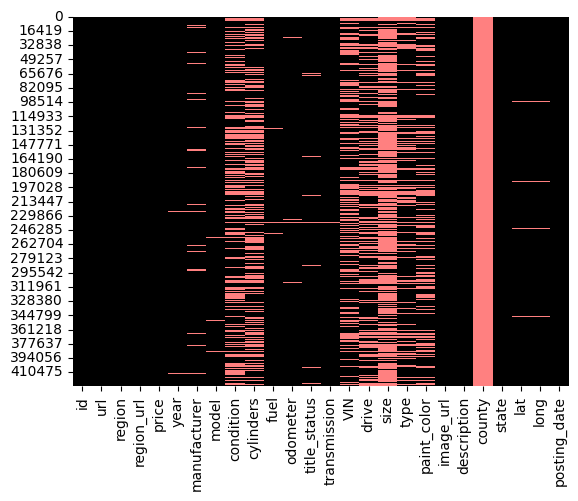

In [111]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    'custom', [(0, 0, 0), (1, 1, 1), (1, 0.5, 0.5)])

# Generate the missing values matrix
msk = df.isna()

# Generate the heatmap with the custom color map
sns.heatmap(msk, cmap=custom_cmap, cbar=False)

In [112]:
def get_missing_correlation(df):
    """
    Get the correlation matrix of missing values in a DataFrame.

    Parameters:
    -----------
    df: pandas DataFrame
        The DataFrame to check for missing value correlation.

    Returns:
    --------
    Tuple
        A tuple containing a boolean indicating if there is high correlation, 
        the mean correlation, the max correlation, and the column pairs with the 
        highest correlation.
    """
    # Create a missing values matrix
    msk = df.isna()

    # Calculate the correlation matrix of the missing values matrix
    corr_matrix = np.abs(msk.corr())

    # Replace NaN values with 0
    corr_matrix = np.nan_to_num(corr_matrix)
    
    # Set diagonal to 0
    np.fill_diagonal(corr_matrix, 0)

    # Calculate the mean and max correlation across all pairs of features
    mean_corr = np.mean(corr_matrix)
    max_corr = np.max(np.nan_to_num(corr_matrix))

    # Find the column pairs with the highest correlation
    max_corr_idxs = np.argwhere((0.5 <= corr_matrix) & 
                                (corr_matrix <= max_corr))
    max_corr_pairs = [(df.columns[i], df.columns[j]) for i, j in zip(*max_corr_idxs.T)]

    # Return True if the mean correlation is greater than 0.5, False otherwise
    if mean_corr > 0.5:
        return True, mean_corr, max_corr, max_corr_pairs
    else:
        return False, mean_corr, max_corr, max_corr_pairs


    
    
    
get_missing_correlation(df)


(False,
 0.05491979425755076,
 1.0,
 [('image_url', 'description'),
  ('image_url', 'posting_date'),
  ('description', 'image_url'),
  ('description', 'posting_date'),
  ('lat', 'long'),
  ('long', 'lat'),
  ('posting_date', 'image_url'),
  ('posting_date', 'description')])

In [113]:
# create a dictionary to map state abbreviations to full names
state_dict = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming'
}

# Group the data by state and count the number of listings in each state
state_counts = df.groupby('state').size().reset_index(name='count')

# Calculate the mean and median price by state
state_price = df.groupby('state')['price'].agg(['median']).reset_index()

# Map state abbreviations to full names in the state_counts and state_price DataFrames
state_counts['state'] = state_counts['state'].str.upper().map(state_dict)
state_price['state'] = state_price['state'].str.upper().map(state_dict)

# Create a choropleth map using folium
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Add layer for listing frequency
m.choropleth(
    geo_data='us-states.json',
    name='Listing Frequency',
    data=state_counts,
    columns=['state', 'count'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Number of Listings',
    legend_scale=5000  # set legend scale to increase the size
)


# Add layer for median price
m.choropleth(
    geo_data='us-states.json',
    name='Median Price',
    data=state_price,
    columns=['state', 'median'],
    key_on='feature.properties.name',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Price ($)',
    legend_scale=5000  # set legend scale to increase the size
)

folium.LayerControl().add_to(m)

m

c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(
c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\folium\folium.py:465: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


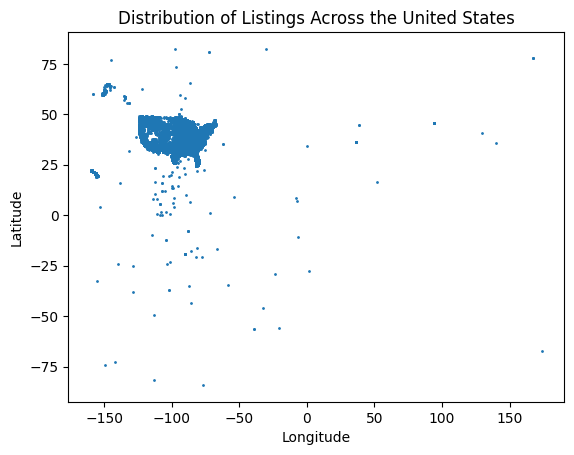

In [114]:
import matplotlib.pyplot as plt

# create a scatter plot of latitudes and longitudes
plt.scatter(df['long'], df['lat'], s=1)

# set axis labels and plot title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Distribution of Listings Across the United States')

# show the plot
plt.show()

In [115]:
df_temp = df.dropna(subset=['lat', 'long']).copy(deep=True)  # remove rows with missing lat/long
df_temp = df_temp.sample(n=1000, random_state=42)

# Create a map centered on the US
us_map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Create a feature group to hold the markers
marker_group = folium.FeatureGroup(name='Listings')

# Add a marker for each listing
for index, row in df_temp.iterrows():
    # Create a popup with some information about the listing
    popup_text = f"Model: {row['model']}<br>Price: {row['price']}"
    
    # Add the marker to the marker group
    folium.Marker(location=[row['lat'], row['long']], popup=popup_text).add_to(marker_group)

# Add the marker group to the map
marker_group.add_to(us_map)

# Add a layer control to the map
folium.LayerControl().add_to(us_map)
# Show the map
us_map

In [116]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url', 'description'])
df_clean.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [117]:
from scipy.stats import percentileofscore

arr = np.array(df['price'])

# Find percentile of a value
percentilelo = percentileofscore(arr, 200)
percentilehi = percentileofscore(arr, 350000)

print(percentilelo, percentilehi)
print(percentilehi-percentilelo)

8.841946214392804 99.98313343328336
91.14118721889055


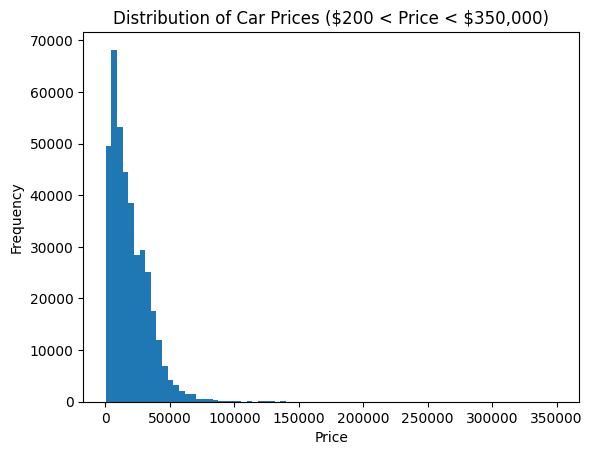

In [118]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url'])
df_clean = df_clean[(df_clean['price'] > 200) & (df_clean['price'] < 350000)]




# Plot histogram of price
plt.hist(df_clean['price'], bins=80, range=(df_clean['price'].quantile(0), df_clean['price'].quantile(1)))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Car Prices (\$200 < Price < \$350,000)')
plt.show()


In [119]:
df_clean['price'].describe()

count    389034.000000
mean      19133.746788
std       15289.913373
min         201.000000
25%        7500.000000
50%       15590.000000
75%       27982.000000
max      349999.000000
Name: price, dtype: float64

In [120]:
arr = np.array(df_clean['price'])

# Find percentile of a value
percentilelo = percentileofscore(arr, 0)
percentilehi = percentileofscore(arr, 46000)

print(percentilelo, percentilehi)
print(percentilehi-percentilelo)

0.0 95.34565102278978
95.34565102278978


In [121]:
df_clean.shape

(389034, 21)

In [122]:
df[df['price']==df_clean['price'].max()]

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
45428,7306488355,https://palmsprings.craigslist.org/ctd/d/palm-...,palm springs,https://palmsprings.craigslist.org,349999,2020.0,ferrari,f8 tributo,excellent,8 cylinders,...,NaN,coupe,NaN,https://images.craigslist.org/00909_j4EPGT4nxI...,ONE OF A KIND 2020 Ferrari F8 Tributo Coupe ...,NaN,ca,33.743904,-116.359028,2021-04-13T18:20:46-0700


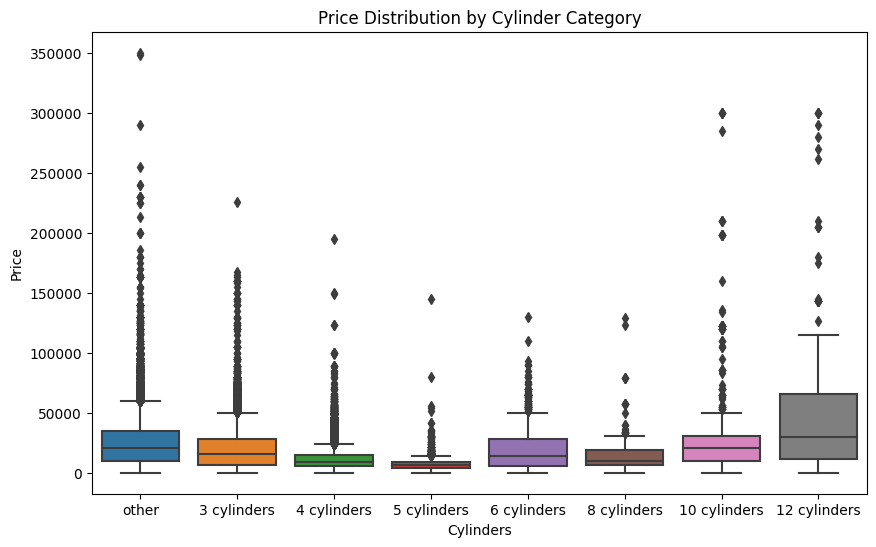

In [123]:
# create a dictionary to map cylinder categories to numerical values
cylinder_order = {'other': 0, '3 cylinders': 1, '4 cylinders': 2, '5 cylinders': 3, '6 cylinders': 4, '8 cylinders': 5, '10 cylinders': 6, '12 cylinders': 7}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean.copy(deep=True)
df_bp['cylinders_order'] = df_bp['cylinders'].map(cylinder_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='cylinders', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Cylinder Category')
ax.set_xlabel('Cylinders')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the cylinder categories
plt.xticks(range(len(cylinder_order)), sorted(cylinder_order, key=lambda x: cylinder_order[x]))

# display the plot
plt.show()

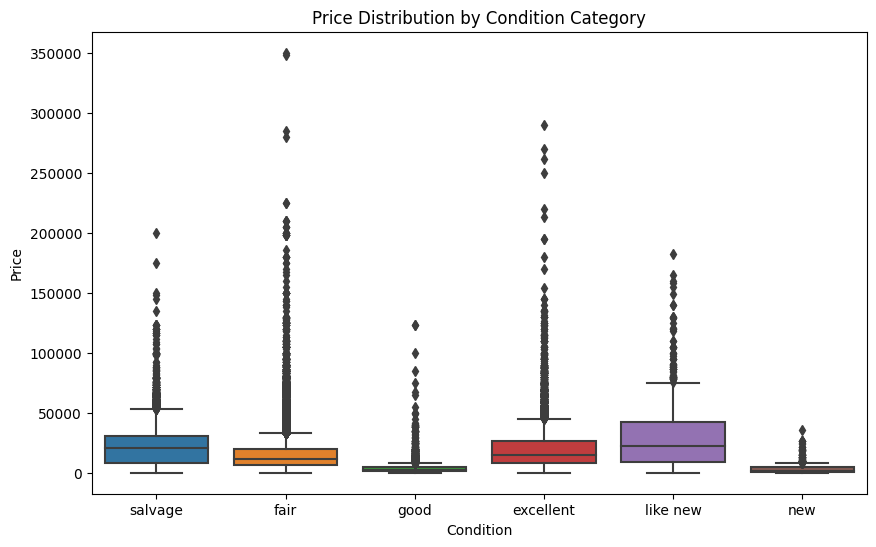

In [124]:
# create a dictionary to map condition categories to numerical values
condition_order = {'salvage': 0, 'fair': 1, 'good': 2, 'excellent': 3, 'like new': 4, 'new': 5}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean.copy(deep=True)
df_bp['condition_order'] = df_bp['condition'].map(condition_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='condition', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Condition Category')
ax.set_xlabel('Condition')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the condition categories
plt.xticks(range(len(condition_order)), sorted(condition_order, key=lambda x: condition_order[x]))

# display the plot
plt.show()

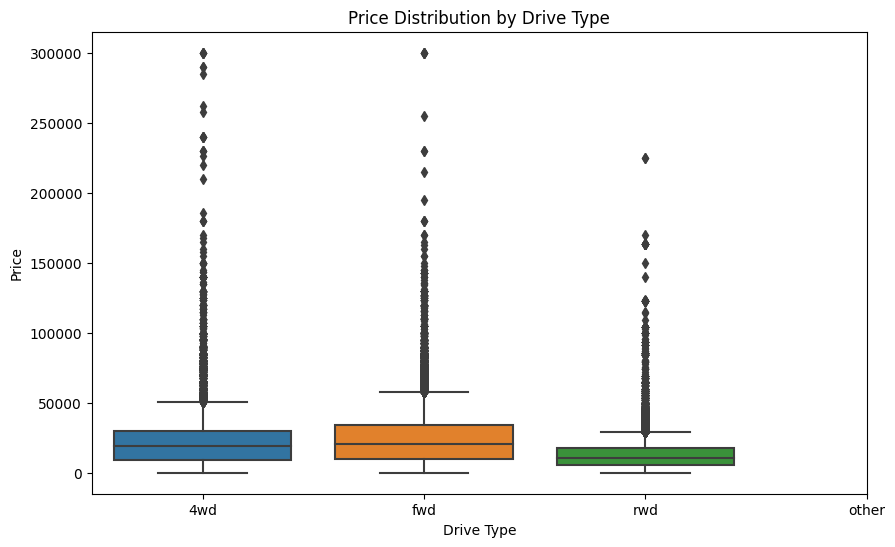

In [125]:
# create a dictionary to map drive type categories to numerical values
drive_order = {'4wd': 0, 'fwd': 1, 'rwd': 2, 'other': 3}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean.copy(deep=True)
df_bp['drive_order'] = df_bp['drive'].map(drive_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='drive', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Drive Type')
ax.set_xlabel('Drive Type')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the drive type categories
plt.xticks(range(len(drive_order)), sorted(drive_order, key=lambda x: drive_order[x]))

# display the plot
plt.show()

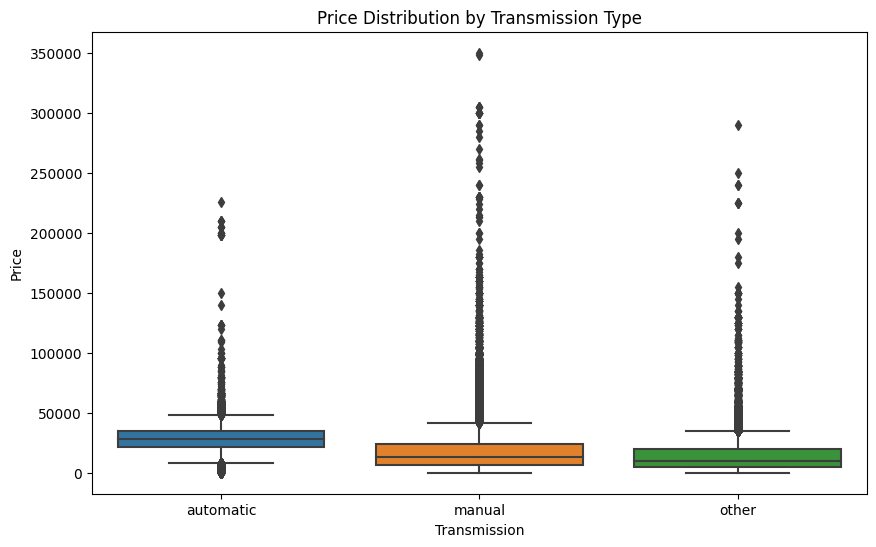

In [126]:
# create a dictionary to map condition categories to numerical values
transmission_order = {'automatic': 0, 'manual': 1, 'other': 2}

# create a new column in the DataFrame with the numerical values
df_bp = df_clean.copy(deep=True)
df_bp['transmission_order'] = df_bp['transmission'].map(transmission_order)

# create a boxplot
fig, ax = plt.subplots(figsize=(10, 6))  # set the figsize parameter to adjust the plot width
sns.boxplot(x='transmission', y='price', data=df_bp, whis=1, ax=ax)

# set title and axis labels
ax.set_title('Price Distribution by Transmission Type')
ax.set_xlabel('Transmission')
ax.set_ylabel('Price')

# set the tick labels for the x-axis to the transmission categories
plt.xticks(range(len(transmission_order)), sorted(transmission_order, key=lambda x: transmission_order[x]))

# display the plot
plt.show()

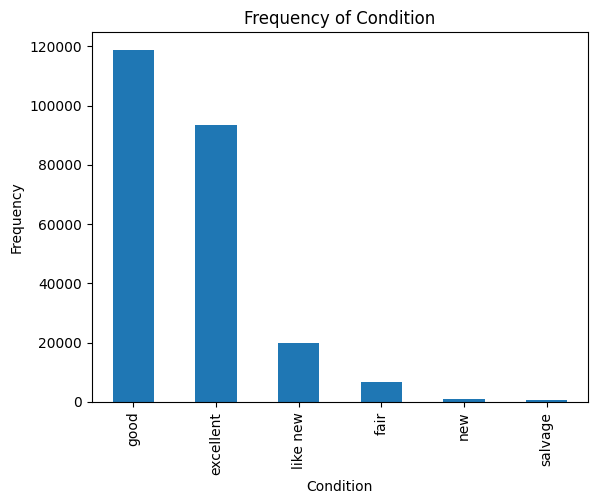

In [127]:
# count the frequency of each condition
condition_counts = df_clean['condition'].value_counts()

# create a bar chart
ax = condition_counts.plot(kind='bar')

# set title and axis labels
ax.set_title('Frequency of Condition')
ax.set_xlabel('Condition')
ax.set_ylabel('Frequency')

# display the plot
plt.show()

In [128]:
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

def get_corr_with_price(df):
    # select only the numerical columns
    numerical_cols = df.select_dtypes(include=[np.number]).columns
    
    # create a new DataFrame to store the results
    result_df = pd.DataFrame(columns=["column_name", "corr_with_price", "r_squared"])
    
    # loop over the numerical columns
    for col in numerical_cols:
        # drop any rows that contain missing values in the selected column
        df_temp = df.dropna(subset=[col])
        
        # create a new DataFrame with the selected column and the price column
        X = df_temp[[col]]
        y = df_temp["price"]
        
        # impute missing values with the mean of the column
        imputer = SimpleImputer()
        X_imputed = imputer.fit_transform(X)
        
        # fit a linear regression model to the data and calculate R^2
        model = LinearRegression()
        model.fit(X_imputed, y)
        r_squared = model.score(X_imputed, y)
        
        # calculate the Pearson correlation coefficient with the "price" column
        corr_with_price = df_temp[[col, "price"]].corr().iloc[0,1]
        
        # append the results to the result DataFrame
        result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
    
    # sort by absolute correlation values in descending order
    result_df = result_df.iloc[(-result_df['corr_with_price'].abs()).argsort()]
    
    return result_df

df_corr_with_price = get_corr_with_price(df_clean)
df_corr_with_price

C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_11380\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_11380\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignore_index=True)
C:\Users\Zaki Ahmed\AppData\Local\Temp\ipykernel_11380\3503054492.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append({"column_name": col, "corr_with_price": corr_with_price, "r_squared": r_squared}, ignor

,column_name,corr_with_price,r_squared
0,price,1.000000,1.000000
1,year,0.331266,0.109737
2,odometer,-0.175103,0.030661
4,long,-0.080492,0.006479
3,lat,-0.011804,0.000139


In [129]:
df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url','description'])
df_clean = df_clean[(df_clean['price'] > 200) & (df_clean['price'] < 350000)]
df_clean.head(10)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state,lat,long,posting_date
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
5,hudson valley,1600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
6,hudson valley,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
7,hudson valley,15995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ny,NaN,NaN,NaN
8,medford-ashland,5000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,or,NaN,NaN,NaN
9,erie,3000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pa,NaN,NaN,NaN


In [130]:
from sklearn.model_selection import train_test_split

#this was necessary to run on my machine
df_sampled = df_clean.sample(
    n=60000, 
    #frac = 1,
    random_state=42)


# Splitting into X and y
X = df_sampled.drop('price', axis=1)
y = df_sampled['price']

# Splitting into train, validation, and test sets
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42) 

# Printing the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48000, 19)
y_train shape: (48000,)
X_val shape: (6000, 19)
y_val shape: (6000,)
X_test shape: (6000, 19)
y_test shape: (6000,)


In [131]:
df_clean.dtypes

region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
lat             float64
long            float64
posting_date     object
dtype: object

In [171]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder

# Define the categorical, numerical, and ordinal features
categorical_features = [
    'region', 
    'manufacturer', 
    'model', 
    'cylinders', 
    'fuel',  
    'transmission', 
    'drive', 
    'size', 
    'type', 
    'paint_color', 
    'state',
]
numerical_features = ['odometer', 'lat', 'long']
ordinal_features = ['posting_date', 'title_status', 'condition','year']

# Define the column transformer with SimpleImputer for missing values
preprocessor = ColumnTransformer(transformers=[
    ('cat', Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='constant', fill_value='Not Given')),
                            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))]), categorical_features),
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())]), numerical_features),
    ('ord', Pipeline(steps=[('imputer',             
                            SimpleImputer(strategy='most_frequent')),
                            ('encoder', 
                             OrdinalEncoder(handle_unknown='use_encoded_value',
                                            unknown_value=-1))]), 
     ordinal_features)
    ], remainder='drop', sparse_threshold=0)

# Define the pipeline
preproc_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline to the training set
X_train_preprocessed = preproc_pipeline.fit_transform(X_train)

# Apply the pipeline to the validation and test sets
X_val_preprocessed = preproc_pipeline.transform(X_val)
X_test_preprocessed = preproc_pipeline.transform(X_test)

preprocessed_sets = {
    'X_train': X_train_preprocessed,
    'X_val': X_val_preprocessed,
    'X_test': X_test_preprocessed
}

c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [133]:
X_train_preprocessed.shape

(48000, 9626)

In [134]:
# Check for missing values in X_train_preprocessed
print(np.isnan(X_train_preprocessed).sum())

# Check for missing values in X_valid_preprocessed
print(np.isnan(X_val_preprocessed).sum())

# Check for missing values in X_test_preprocessed
print(np.isnan(X_test_preprocessed).sum())


0
0
0


In [135]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd

# Get the median price from the training set
median_price = y_train.median()

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Define your model (predicts median price)
class MedianRegressor:
    def __init__(self, median_price):
        self.median_price = median_price
    
    def fit(self, X, y):
        pass
    
    def predict(self, X):
        return np.full(X.shape[0], self.median_price)

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each fold
    fold_scores = np.zeros(n_folds)
    
    # Loop over the folds and train the model on each fold
    for i, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        # Split the data into training and validation sets
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]
        
        # Fit the model on the training data
        model = MedianRegressor(median_price)
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions on the validation data
        y_pred = model.predict(X_val_fold)
        
        # Calculate the RMSE for the current fold
        fold_scores[i] = mean_squared_error(y_val_fold, y_pred, squared=False)
    
    # Calculate the average RMSE across all folds for the current run and each set
    rmse_scores[run, 0] = np.mean(fold_scores)  # Train set performance
    rmse_scores[run, 1] = mean_squared_error(y_val, np.full(X_val.shape[0], median_price), squared=False)  # Validation set performance
    rmse_scores[run, 2] = mean_squared_error(y_test, np.full(X_test.shape[0], median_price), squared=False)  # Test set performance

# Calculate the average RMSE across all runs and each set
avg_rmse = np.mean(rmse_scores, axis=0)
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Create a dataframe to store the RMSE scores
rmse_df = pd.DataFrame(np.zeros((4, 1)), columns=['Median Regressor'])
rmse_df.index = ['Train Set Performance', 'Validation Set Performance', 'Test Set Performance', 'Average across all Sets']

# Assign the average RMSE scores to the dataframe
rmse_df.iloc[0, 0] = avg_rmse_train
rmse_df.iloc[1, 0] = avg_rmse_val
rmse_df.iloc[2, 0] = avg_rmse_test
rmse_df.iloc[3, 0] = np.mean(avg_rmse)

rmse_df


,Median Regressor
Train Set Performance,15517.838743
Validation Set Performance,16267.278403
Test Set Performance,16264.411548
Average across all Sets,16016.509565


In [137]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Define your model
model = LinearRegression(n_jobs=-1)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Fit the model on the training data
    X_train_iter = preproc_pipeline.transform(X_train)
    model.fit(X_train_iter, y_train)
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train_iter)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the validation set and calculate the RMSE
    y_val_pred = model.predict(X_val_preprocessed)
    set_scores[1] = mean_squared_error(y_val, y_val_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    y_test_pred = model.predict(X_test_preprocessed)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])


rmse_df['Linear Regressor'] = [avg_rmse_train,avg_rmse_val,avg_rmse_test, avg_rmse]


rmse_df

,Median Regressor,Linear Regressor
Train Set Performance,15517.838743,7.296693e+03
Validation Set Performance,16267.278403,3.708107e+07
Test Set Performance,16264.411548,4.925165e+09
Average across all Sets,16016.509565,1.654084e+09


In [142]:
## for XGBoost

## age feature engineering
df_clean['age'] =(
     df_clean['posting_date'].apply(lambda x: np.float32(str(x)[:4])) - df_clean['year'])

#this was necessary to run on my machine
df_sampled_xg = df_clean.sample(
    n=60000, 
    #frac = 1,
    random_state=42)


def convert_to_category(col):
    if col.dtypes == 'object':
        return col.astype('category')
    else:
        return col
data_final_XG = df_sampled_xg.apply(convert_to_category)

# Splitting into X and y
X = data_final_XG.drop('price', axis=1)
y = data_final_XG['price']

# Splitting into train, validation, and test sets
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42) 

# Printing the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (48000, 20)
y_train shape: (48000,)
X_val shape: (6000, 20)
y_val shape: (6000,)
X_test shape: (6000, 20)
y_test shape: (6000,)


In [143]:
X_train.dtypes

region          category
year             float64
manufacturer    category
model           category
condition       category
cylinders       category
fuel            category
odometer         float64
title_status    category
transmission    category
VIN             category
drive           category
size            category
type            category
paint_color     category
state           category
lat              float64
long             float64
posting_date    category
age              float64
dtype: object

In [150]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define your model
model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror', random_state=42, enable_categorical=True)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Fit the model on the training data
    X_train_iter = preproc_pipeline.transform(X_train)
    model.fit(X_train_iter, y_train)
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train_iter)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the validation set and calculate the RMSE
    X_val_iter = preproc_pipeline.transform(X_val)
    y_val_pred = model.predict(X_val_iter)
    set_scores[1] = mean_squared_error(y_val, y_val_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    X_test_preprocessed = preproc_pipeline.transform(X_test)
    y_test_pred = model.predict(X_test_preprocessed)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Add the average RMSE performance for the XGBoost model to the rmse_df dataframe
rmse_df['XGBoost Regressor + PCA (Untuned)'] = [avg_rmse_train, avg_rmse_val, avg_rmse_test, avg_rmse]

In [149]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define your model
model = xgb.XGBRegressor(tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror', random_state=42, enable_categorical=True)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Split the train set into folds and fit the model on each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Fit the model on the fold's training data
        model.fit(X_fold_train, y_fold_train)
        
        # Make predictions on the fold's validation data and calculate the RMSE
        y_fold_val_pred = model.predict(X_fold_val)
        set_scores[1] += mean_squared_error(y_fold_val, y_fold_val_pred, squared=False)
    
    # Average the RMSE for the validation sets across all folds
    set_scores[1] /= n_folds
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    y_test_pred = model.predict(X_test)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Add the average RMSE performance for the XGBoost model to the rmse_df dataframe
rmse_df['XGBoost Regressor (Untuned)'] = [avg_rmse_train, avg_rmse_val, avg_rmse_test, avg_rmse]


In [155]:
rmse_df = rmse_df.drop(columns=['XGBoost Regressor PCA']) #Erroneous column name
rmse_df

,Median Regressor,Linear Regressor,XGBoost Regressor (Untuned),XGBoost Regressor + PCA (Untuned)
Train Set Performance,15517.838743,7.296693e+03,5225.006828,6495.112200
Validation Set Performance,16267.278403,3.708107e+07,8565.120962,8639.367477
Test Set Performance,16264.411548,4.925165e+09,9500.483124,8671.188608
Average across all Sets,16016.509565,1.654084e+09,7763.536971,7935.222761


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

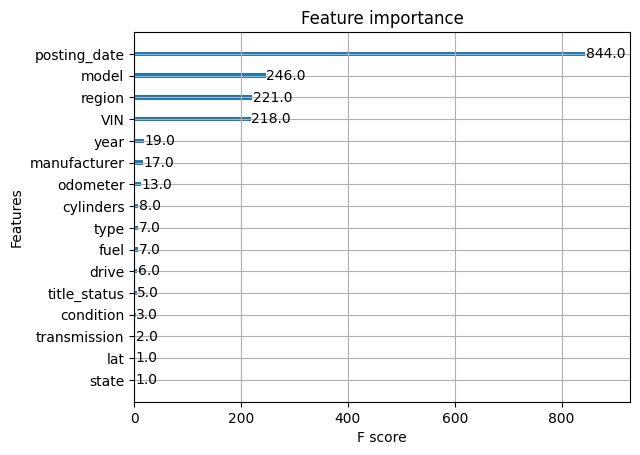

In [147]:
xgb.plot_importance(model)

In [156]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# Define the categorical, numerical, and ordinal features
categorical_features = [
    'region', 
    'manufacturer', 
    'model', 
    'cylinders', 
    'fuel',  
    'transmission', 
    'drive', 
    'size', 
    'type', 
    'paint_color', 
    'state',
]
numerical_features = ['odometer', 'lat', 'long', 'age']
ordinal_features = ['posting_date', 'title_status', 'condition','year']

# Define the column transformer with SimpleImputer for missing values
preprocessor = ColumnTransformer(transformers=[
    ('cat', SimpleImputer(strategy='constant', fill_value='Not Given'), categorical_features),
    ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                            ('scaler', StandardScaler())]), numerical_features),
    ('ord', Pipeline(steps=[('imputer', 
                             SimpleImputer(strategy='most_frequent')),
                            ('encoder', OrdinalEncoder(handle_unknown= 'use_encoded_value', unknown_value=-1))]), ordinal_features)
    ], remainder='drop', sparse_threshold=0)

# Define the pipeline
preproc_pipeline_xg = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit the pipeline to the training set
X_train_preprocessed_xg = preproc_pipeline.fit_transform(X_train)

# Apply the pipeline to the validation and test sets
X_val_preprocessed_xg = preproc_pipeline.transform(X_val)
X_test_preprocessed_xg = preproc_pipeline.transform(X_test)

preprocessed_sets_xg = {
    'X_train': X_train_preprocessed_xg,
    'X_val': X_val_preprocessed_xg,
    'X_test': X_test_preprocessed_xg
}

c:\Users\Zaki Ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [167]:
rmse_df

,Median Regressor,Linear Regressor,XGBoost Regressor (Untuned),XGBoost Regressor + PCA (Untuned),KNN Regressor
Train Set Performance,15517.838743,7.296693e+03,5225.006828,6495.112200,10743.563408
Validation Set Performance,16267.278403,3.708107e+07,8565.120962,8639.367477,15753.046090
Test Set Performance,16264.411548,4.925165e+09,9500.483124,8671.188608,15747.495305
Average across all Sets,16016.509565,1.654084e+09,7763.536971,7935.222761,14081.368268


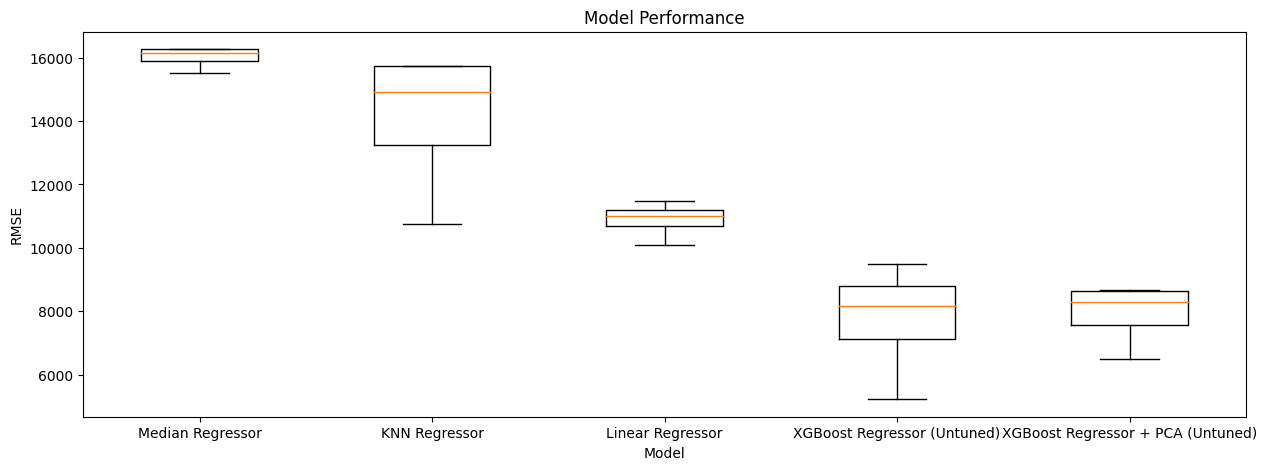

In [166]:
import matplotlib.pyplot as plt

# Data to plot
median_regressor = [15517.838743, 16267.278403, 16264.411548, 16016.509565]
linear_regressor = [10094.398393, 11493.355072, 11100.875569, 10896.209678]
xgboost_regressor_untuned = [5225.006828, 8565.120962, 9500.483124,7763.536971]
xgboost_regressor_pca = [6495.112200, 8639.367477, 8671.188608,7935.222761]
knn_regressor = [10743.563408, 15753.046090, 15747.495305, 14081.368268]

data = [median_regressor, knn_regressor, linear_regressor, xgboost_regressor_untuned, xgboost_regressor_pca]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Create a box plot of the data
ax.boxplot(data, labels=['Median Regressor', 'KNN Regressor', 'Linear Regressor', 'XGBoost Regressor (Untuned)', 'XGBoost Regressor + PCA (Untuned)'])

# Add titles and axis labels
ax.set_title('Model Performance')
ax.set_ylabel('RMSE')
ax.set_xlabel('Model')

# Display the plot
plt.show()

In [180]:
# from sklearn.model_selection import GriddSearchCV

# # define the model
# xgb_model = xgb.XGBRegressor(enable_categorical=True)

# # define the hyperparameters and their values to be tuned
# param_grid = {'n_estimators': [100, 150, 400],
#               #'learning_rate': [0.1, 0.05, 0.01],
#               #'max_depth': [3, 5, 7],
#               'subsample': [0.5, 0.8, 1],
#               #'colsample_bytree': [0.7, 0.8, 0.9],
#               'objective': ['reg:squarederror'],
#               'eval_metric': ['rmse'],
#               'tree_method': ['gpuhist']}

# # perform search cross-validation
# search = GridSearchCV(estimator=xgb_model,
#                             param_distributions=param_grid,
#                             scoring='roc_auc',
#                             cv=5,
#                             n_jobs=-1)

# search.fit(X_train_preprocessed, y_train)

# # predict on the validation set and print the validation score
# y_pred = search.predict(X_val_preprocessed)
# val_score = mean_squared_error(y_val, y_pred, squared=False)
# print("Validation score: {:.2f}".format(val_score))

# # print the best hyperparameters and the corresponding mean cross-validation score
# print("Best hyperparameters: ", search.best_params_)
# print("Best mean cross-validation score: {:.2f}".format(search.best_score_))

### disabled for notebook final run hyperparameters found below:

print("Best Params for Approach 1: tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror', eval_metric='rmse',  random_state=42,enable_categorical=True, max_depth = 5, n_estimators=150, learning_rate= 0.1, subsample=0.8" )
print("Best Params for Approach 2: tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror', eval_metric='rmse',  random_state=42,enable_categorical=True, max_depth = 5, n_estimators=150, learning_rate= 0.1, subsample=0.8" )

Best Params for Approach 1: tree_method='gpu_hist', gpu_id=0, objective='reg:squarederror', eval_metric='rmse',  random_state=42,enable_categorical=True, max_depth = 5, n_estimators=150, learning_rate= 0.1, subsample=0.8


In [173]:
# Define your model
model = xgb.XGBRegressor(
    tree_method='gpu_hist', 
    gpu_id=0, 
    objective='reg:squarederror',
    eval_metric='rmse', 
    random_state=42, 
    enable_categorical=True, 
    max_depth = 5, 
    n_estimators=150, 
    learning_rate= 0.1, 
    subsample=0.8)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Split the train set into folds and fit the model on each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Fit the model on the fold's training data
        model.fit(X_fold_train, y_fold_train)
        
        # Make predictions on the fold's validation data and calculate the RMSE
        y_fold_val_pred = model.predict(X_fold_val)
        set_scores[1] += mean_squared_error(y_fold_val, y_fold_val_pred, squared=False)
    
    # Average the RMSE for the validation sets across all folds
    set_scores[1] /= n_folds
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    y_test_pred = model.predict(X_test)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Add the average RMSE performance for the XGBoost model to the rmse_df dataframe
rmse_df['XGBoost Regressor (Tuned)'] = [avg_rmse_train, avg_rmse_val, avg_rmse_test, avg_rmse]

In [177]:
rmse_df

,Median Regressor,Linear Regressor,XGBoost Regressor (Untuned),XGBoost Regressor + PCA (Untuned),KNN Regressor,XGBoost Regressor (Tuned)
Train Set Performance,15517.838743,7.296693e+03,5225.006828,6495.112200,10743.563408,4227.407411
Validation Set Performance,16267.278403,3.708107e+07,8565.120962,8639.367477,15753.046090,8767.422331
Test Set Performance,16264.411548,4.925165e+09,9500.483124,8671.188608,15747.495305,8540.006414
Average across all Sets,16016.509565,1.654084e+09,7763.536971,7935.222761,14081.368268,7178.278718


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

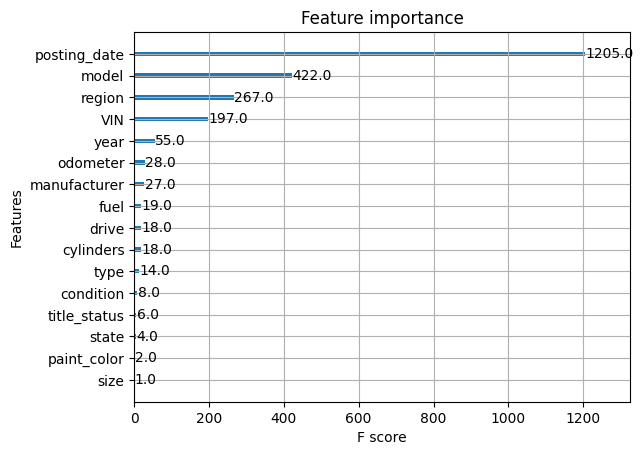

In [175]:
xgb.plot_importance(model)

In [178]:

# Define your model
model = xgb.XGBRegressor(
    tree_method='gpu_hist', 
    gpu_id=0, 
    objective='reg:squarederror',
    eval_metric='rmse', 
    random_state=42, 
    enable_categorical=True, 
    max_depth = 7, 
    n_estimators=180, 
    learning_rate= 0.1, 
    subsample=0.8)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Fit the model on the training data
    X_train_iter = preproc_pipeline.transform(X_train)
    model.fit(X_train_iter, y_train)
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train_iter)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the validation set and calculate the RMSE
    X_val_iter = preproc_pipeline.transform(X_val)
    y_val_pred = model.predict(X_val_iter)
    set_scores[1] = mean_squared_error(y_val, y_val_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    X_test_preprocessed = preproc_pipeline.transform(X_test)
    y_test_pred = model.predict(X_test_preprocessed)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Add the average RMSE performance for the XGBoost model to the rmse_df dataframe
rmse_df['XGBoost Regressor + PCA (Tuned)'] = [avg_rmse_train, avg_rmse_val, avg_rmse_test, avg_rmse] 

In [179]:
rmse_df

,Median Regressor,Linear Regressor,XGBoost Regressor (Untuned),XGBoost Regressor + PCA (Untuned),KNN Regressor,XGBoost Regressor (Tuned),XGBoost Regressor + PCA (Tuned)
Train Set Performance,15517.838743,7.296693e+03,5225.006828,6495.112200,10743.563408,4227.407411,6189.694667
Validation Set Performance,16267.278403,3.708107e+07,8565.120962,8639.367477,15753.046090,8767.422331,8497.891847
Test Set Performance,16264.411548,4.925165e+09,9500.483124,8671.188608,15747.495305,8540.006414,8162.934866
Average across all Sets,16016.509565,1.654084e+09,7763.536971,7935.222761,14081.368268,7178.278718,7616.840460


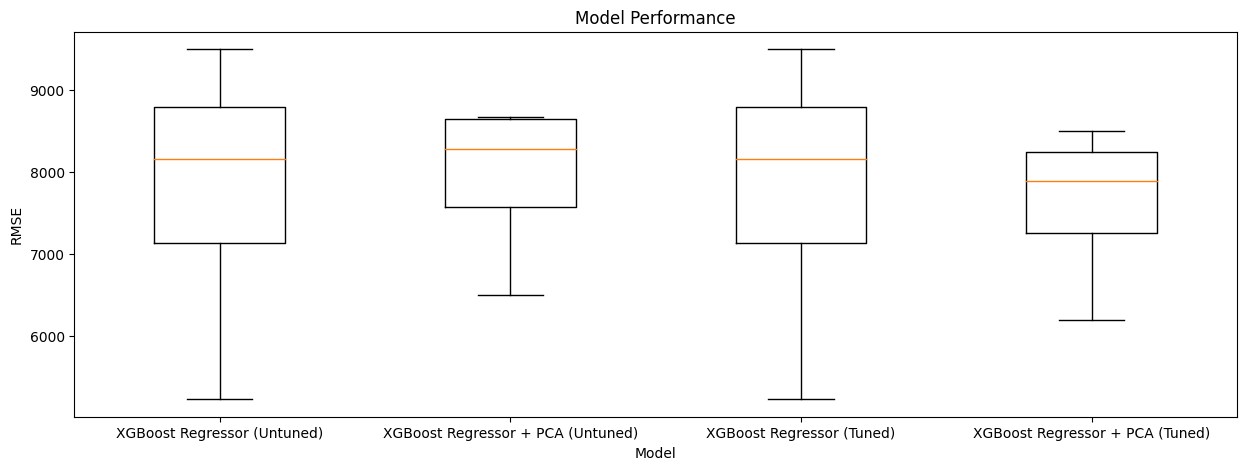

In [190]:
# Data to plot
median_regressor = [15517.838743, 16267.278403, 16264.411548, 16016.509565]
linear_regressor = [10094.398393, 11493.355072, 11100.875569, 10896.209678]
xgboost_regressor_untuned = [5225.006828, 8565.120962, 9500.483124,7763.536971]
xgboost_regressor_tuned = [5225.006828, 8565.120962, 9500.483124,7763.536971]
xgboost_regressor_pca = [6495.112200, 8639.367477, 8671.188608,7935.222761]
xgboost_regressor_pca_tuned = [6189.694667,8497.891847,8162.934866,7616.840460]
knn_regressor = [10743.563408, 15753.046090, 15747.495305, 14081.368268]

data = [xgboost_regressor_untuned, xgboost_regressor_pca, xgboost_regressor_tuned,xgboost_regressor_pca_tuned]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Create a box plot of the data
ax.boxplot(data, labels=['XGBoost Regressor (Untuned)', 'XGBoost Regressor + PCA (Untuned)', 'XGBoost Regressor (Tuned)','XGBoost Regressor + PCA (Tuned)'])

# Add titles and axis labels
ax.set_title('Model Performance')
ax.set_ylabel('RMSE')
ax.set_xlabel('Model')

# Display the plot
plt.show()

In [181]:
X_train.columns

Index(['region', 'year', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'VIN', 'drive',
       'size', 'type', 'paint_color', 'state', 'lat', 'long', 'posting_date',
       'age'],
      dtype='object')

In [186]:
## for XGBoost investigating missing values / imputation possibly negatively impacting performance

df_clean = df.drop(columns=['county', 'id', 'url', 'region_url', 'image_url','description'])
df_clean = df_clean[(df_clean['price'] > 200) & (df_clean['price'] < 350000)]

df_clean = df_clean.dropna()

## age feature engineering
df_clean['age'] =(
     df_clean['posting_date'].apply(lambda x: np.float32(str(x)[:4])) - df_clean['year'])



def convert_to_category(col):
    if col.dtypes == 'object':
        return col.astype('category')
    else:
        return col
data_final_XG = df_clean.apply(convert_to_category)

# Splitting into X and y
X = data_final_XG.drop('price', axis=1)
y = data_final_XG['price']

# Splitting into train, validation, and test sets
X_train, X_testval, y_train, y_testval = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval, test_size=0.5, random_state=42) 

# Printing the shapes of the resulting arrays
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (25352, 20)
y_train shape: (25352,)
X_val shape: (3169, 20)
y_val shape: (3169,)
X_test shape: (3169, 20)
y_test shape: (3169,)


In [187]:
# Define your model
model = xgb.XGBRegressor(
    tree_method='gpu_hist', 
    gpu_id=0, 
    objective='reg:squarederror',
    eval_metric='rmse', 
    random_state=42, 
    enable_categorical=True, 
    max_depth = 5, 
    n_estimators=150, 
    learning_rate= 0.1, 
    subsample=0.8)

# Define the number of runs and the number of folds for each run
n_runs = 5
n_folds = 3

# Define the KFold cross-validation object
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# Initialize an array to store the RMSE for each run and each set
rmse_scores = np.zeros((n_runs, 3))

X_train

# Run the model n_runs times
for run in range(n_runs):
    # Initialize an array to store the RMSE for each set
    set_scores = np.zeros(3)
    
    # Split the train set into folds and fit the model on each fold
    for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Fit the model on the fold's training data
        model.fit(X_fold_train, y_fold_train)
        
        # Make predictions on the fold's validation data and calculate the RMSE
        y_fold_val_pred = model.predict(X_fold_val)
        set_scores[1] += mean_squared_error(y_fold_val, y_fold_val_pred, squared=False)
    
    # Average the RMSE for the validation sets across all folds
    set_scores[1] /= n_folds
    
    # Make predictions on the train set and calculate the RMSE
    y_train_pred = model.predict(X_train)
    set_scores[0] = mean_squared_error(y_train, y_train_pred, squared=False)
    
    # Make predictions on the test set and calculate the RMSE
    y_test_pred = model.predict(X_test)
    set_scores[2] = mean_squared_error(y_test, y_test_pred, squared=False)
    
    # Store the RMSE scores for the current run and set
    rmse_scores[run] = set_scores
    
# Calculate the average RMSE across all runs for each set
avg_rmse_train = np.mean(rmse_scores[:, 0])
avg_rmse_val = np.mean(rmse_scores[:, 1])
avg_rmse_test = np.mean(rmse_scores[:, 2])

# Calculate the average RMSE across all runs
avg_rmse = np.mean(rmse_scores)

# Add the average RMSE performance for the XGBoost model to the rmse_df dataframe
rmse_df['XGBoost Regressor + Complete Rows Only (Tuned)'] = [avg_rmse_train, avg_rmse_val, avg_rmse_test, avg_rmse]

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

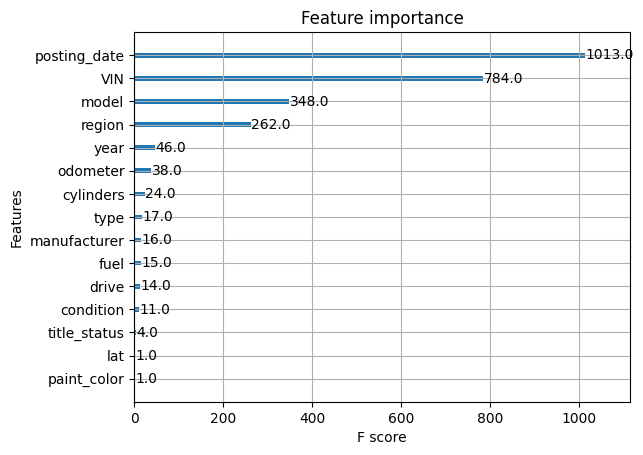

In [192]:
xgb.plot_importance(model)

In [188]:
rmse_df

,Median Regressor,Linear Regressor,XGBoost Regressor (Untuned),XGBoost Regressor + PCA (Untuned),KNN Regressor,XGBoost Regressor (Tuned),XGBoost Regressor + PCA (Tuned),XGBoost Regressor + Complete Rows Only (Tuned)
Train Set Performance,15517.838743,7.296693e+03,5225.006828,6495.112200,10743.563408,4227.407411,6189.694667,3757.924131
Validation Set Performance,16267.278403,3.708107e+07,8565.120962,8639.367477,15753.046090,8767.422331,8497.891847,6098.876851
Test Set Performance,16264.411548,4.925165e+09,9500.483124,8671.188608,15747.495305,8540.006414,8162.934866,6100.994540
Average across all Sets,16016.509565,1.654084e+09,7763.536971,7935.222761,14081.368268,7178.278718,7616.840460,5319.265174


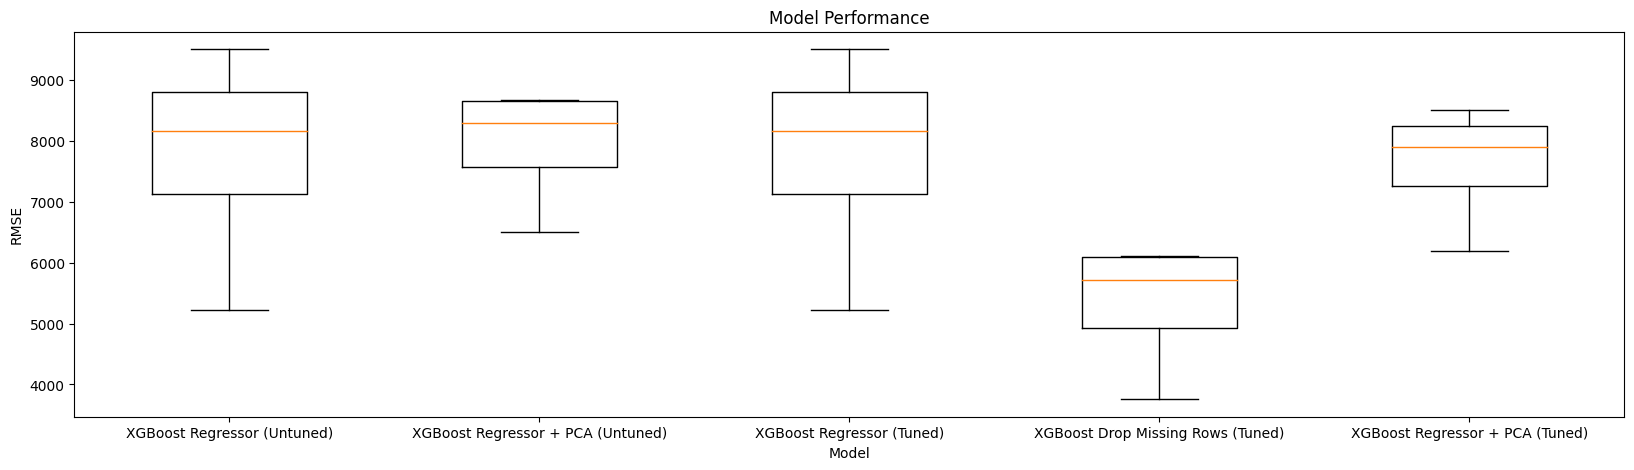

In [193]:
# Data to plot
median_regressor = [15517.838743, 16267.278403, 16264.411548, 16016.509565]
linear_regressor = [10094.398393, 11493.355072, 11100.875569, 10896.209678]
xgboost_regressor_untuned = [5225.006828, 8565.120962, 9500.483124,7763.536971]
xgboost_regressor_tuned = [5225.006828, 8565.120962, 9500.483124,7763.536971]
xgboost_tuned_dna = [3757.924131, 6098.876851, 6100.994540,5319.265174]
xgboost_regressor_pca = [6495.112200, 8639.367477, 8671.188608,7935.222761]
xgboost_regressor_pca_tuned = [6189.694667,8497.891847,8162.934866,7616.840460]
knn_regressor = [10743.563408, 15753.046090, 15747.495305, 14081.368268]

data = [xgboost_regressor_untuned, xgboost_regressor_pca, xgboost_regressor_tuned, xgboost_tuned_dna,xgboost_regressor_pca_tuned]

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(20, 5))

# Create a box plot of the data
ax.boxplot(data, labels=['XGBoost Regressor (Untuned)', 'XGBoost Regressor + PCA (Untuned)', 'XGBoost Regressor (Tuned)','XGBoost Drop Missing Rows (Tuned)','XGBoost Regressor + PCA (Tuned)'])

# Add titles and axis labels
ax.set_title('Model Performance')
ax.set_ylabel('RMSE')
ax.set_xlabel('Model')

# Display the plot
plt.show()